In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [75]:
column_names = ['id','time','latitude','longitude','direction','road','trafficStatus','avgVehicleSpeed','vehicleFlowRate','trafficConcentration','intervehicularDistance','delay','populationDensity','transmissionPower','levelOfService']

In [76]:
train_df=pd.read_csv('data_final.csv', names = column_names,sep=';')

In [77]:
train_df= train_df.dropna()

In [78]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130742 entries, 0 to 149948
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      130742 non-null  object 
 1   time                    130742 non-null  object 
 2   latitude                130742 non-null  float64
 3   longitude               130742 non-null  float64
 4   direction               130742 non-null  object 
 5   road                    130742 non-null  object 
 6   trafficStatus           130742 non-null  object 
 7   avgVehicleSpeed         130742 non-null  float64
 8   vehicleFlowRate         130742 non-null  int64  
 9   trafficConcentration    130742 non-null  float64
 10  intervehicularDistance  130742 non-null  int64  
 11  delay                   130742 non-null  int64  
 12  populationDensity       130742 non-null  int64  
 13  transmissionPower       130742 non-null  int64  
 14  levelOfService      

In [79]:
train_df.head()

,id,time,latitude,longitude,direction,road,trafficStatus,avgVehicleSpeed,vehicleFlowRate,trafficConcentration,intervehicularDistance,delay,populationDensity,transmissionPower,levelOfService
0,A1.GT.24538,2019-11-19T07:39:00.000+01:00,49.667915,6.377110,outboundFromTown,A1,freeFlow,127.0,313,0.0,10,2,30,27,C
1,A1.GT.26600,2019-11-19T07:39:00.000+01:00,49.679363,6.399515,outboundFromTown,A1,freeFlow,120.0,448,1.0,8,5,22,19,A
4,A1.GT.15400,2019-11-19T07:39:00.000+01:00,49.640390,6.263833,outboundFromTown,A1,freeFlow,109.0,274,0.0,11,6,20,28,B
5,A1.TTHOG.2009,2019-11-19T07:39:00.000+01:00,49.578068,6.150946,inboundTowardsTown,A1,freeFlow,86.0,2171,10.0,11,1,25,23,C
6,A1.TG.16951,2019-11-19T07:39:00.000+01:00,49.643085,6.284836,inboundTowardsTown,A1,impossible,29.0,3206,2.0,11,2,22,21,F


In [80]:
train_df['trafficStatus'].value_counts()

freeFlow      95537
congested     32253
unknown        1596
impossible     1356
Name: trafficStatus, dtype: int64

In [81]:
mistakes = ['unknown', 'impossible']
train_df = train_df[train_df.trafficStatus.isin(mistakes) == False]
train_df['trafficStatus'].value_counts()

freeFlow     95537
congested    32253
Name: trafficStatus, dtype: int64

<AxesSubplot:xlabel='trafficStatus', ylabel='count'>

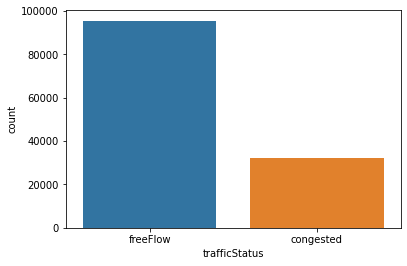

In [82]:
import seaborn as sns
sns.countplot(x="trafficStatus", data = train_df)

In [83]:
train_df['direction'].value_counts()

inboundTowardsTown    65392
outboundFromTown      62398
Name: direction, dtype: int64

<AxesSubplot:xlabel='direction', ylabel='count'>

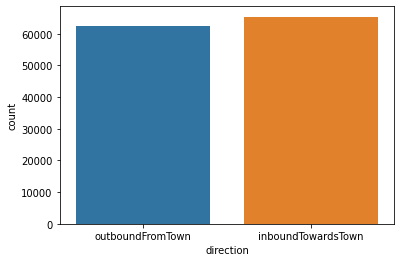

In [84]:
sns.countplot(x="direction", data = train_df)

In [85]:
cols = list(train_df.columns.values)
cols

['id',
 'time',
 'latitude',
 'longitude',
 'direction',
 'road',
 'trafficStatus',
 'avgVehicleSpeed',
 'vehicleFlowRate',
 'trafficConcentration',
 'intervehicularDistance',
 'delay',
 'populationDensity',
 'transmissionPower',
 'levelOfService']

In [86]:
train_df = train_df[['id','time','latitude','longitude','direction','road','avgVehicleSpeed','vehicleFlowRate','trafficConcentration','intervehicularDistance','delay','populationDensity','transmissionPower','levelOfService','trafficStatus']]

In [87]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127790 entries, 0 to 149948
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      127790 non-null  object 
 1   time                    127790 non-null  object 
 2   latitude                127790 non-null  float64
 3   longitude               127790 non-null  float64
 4   direction               127790 non-null  object 
 5   road                    127790 non-null  object 
 6   avgVehicleSpeed         127790 non-null  float64
 7   vehicleFlowRate         127790 non-null  int64  
 8   trafficConcentration    127790 non-null  float64
 9   intervehicularDistance  127790 non-null  int64  
 10  delay                   127790 non-null  int64  
 11  populationDensity       127790 non-null  int64  
 12  transmissionPower       127790 non-null  int64  
 13  levelOfService          127790 non-null  object 
 14  trafficStatus       

In [101]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
train_df['direction']= label_encoder.fit_transform(train_df['direction'])
train_df['road']= label_encoder.fit_transform(train_df['road'])
train_df['levelOfService']= label_encoder.fit_transform(train_df['levelOfService'])

train_df['trafficStatus']= label_encoder.fit_transform(train_df['trafficStatus'])

train_df['direction'].unique()
train_df['road'].unique()
train_df['levelOfService'].unique()
train_df['trafficStatus'].unique()
train_df.head()

,id,time,latitude,longitude,direction,road,avgVehicleSpeed,vehicleFlowRate,trafficConcentration,intervehicularDistance,delay,populationDensity,transmissionPower,levelOfService,trafficStatus
0,A1.GT.24538,2019-11-19T07:39:00.000+01:00,49.667915,6.377110,1,0,127.0,313,0.0,10,2,30,27,2,1
1,A1.GT.26600,2019-11-19T07:39:00.000+01:00,49.679363,6.399515,1,0,120.0,448,1.0,8,5,22,19,0,1
4,A1.GT.15400,2019-11-19T07:39:00.000+01:00,49.640390,6.263833,1,0,109.0,274,0.0,11,6,20,28,1,1
5,A1.TTHOG.2009,2019-11-19T07:39:00.000+01:00,49.578068,6.150946,0,0,86.0,2171,10.0,11,1,25,23,2,1
7,A1.TG.880,2019-11-19T07:39:00.000+01:00,49.574917,6.136453,0,0,86.0,2203,13.0,11,4,23,19,0,1


In [102]:
train_df['trafficStatus'].value_counts()

1    95537
0    32253
Name: trafficStatus, dtype: int64

In [103]:
print(train_df.shape)

(127790, 15)


Reshape X_train and X_test to 3D since Conv1D requires 3D data

In [104]:
X = train_df.iloc[:, 2:14]
y = train_df.iloc[:,14]

In [105]:
X

,latitude,longitude,direction,road,avgVehicleSpeed,vehicleFlowRate,trafficConcentration,intervehicularDistance,delay,populationDensity,transmissionPower,levelOfService
0,49.667915,6.377110,1,0,127.0,313,0.0,10,2,30,27,2
1,49.679363,6.399515,1,0,120.0,448,1.0,8,5,22,19,0
4,49.640390,6.263833,1,0,109.0,274,0.0,11,6,20,28,1
5,49.578068,6.150946,0,0,86.0,2171,10.0,11,1,25,23,2
7,49.574917,6.136453,0,0,86.0,2203,13.0,11,4,23,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...
149944,49.495125,5.944604,0,6,73.0,419,1.0,3,10,16,16,5
149945,49.493904,5.947297,1,6,62.0,500,1.0,1,14,18,14,4
149946,49.493960,5.947337,0,6,59.0,390,2.0,4,12,18,14,3
149947,49.495060,5.944498,1,6,67.0,533,1.0,3,15,18,20,3


In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [107]:
X_train = X_train.values
X_test = X_test.values

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

In [108]:
print(X_train.shape)
print(X_test.shape)

(95842, 12, 1)
(31948, 12, 1)


Convert the Target label to categorical

In [109]:
target_train = y_train
target_test = y_test
Y_train=to_categorical(target_train)
Y_test=to_categorical(target_test)

In [110]:
print(Y_train.shape)
print(Y_test.shape)
Y_train

(95842, 2)
(31948, 2)


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Performance Evaluation Function

In [111]:
def showResults(test, pred):
    #target_names = ['positive', 'negative']
    # print(classification_report(test, pred, target_names=target_names))
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    #loss=log_loss(test,pred)
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    #print("Loss : {}".format(loss))
    cm=confusion_matrix(test, pred)
    print(cm)

Model Defination

# **Hybrid CNN LSTM**

In [112]:
import tensorflow as tf
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,kernel_size=5,strides=1,padding="causal",activation="relu",input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2)
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                             decay_steps=1000000,
                                                             decay_rate=0.98,
                                                             staircase=False)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 64)            384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           82432     
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [113]:
history = model.fit(X_train, Y_train,epochs=10)

Epoch 1/10
2996/2996 [==============================] - 34s 11ms/step - loss: 0.0573 - acc: 0.9527
Epoch 2/10
2996/2996 [==============================] - 43s 14ms/step - loss: 0.0192 - acc: 0.9949
Epoch 3/10
2996/2996 [==============================] - 43s 14ms/step - loss: 0.0140 - acc: 0.9970
Epoch 4/10
2996/2996 [==============================] - 42s 14ms/step - loss: 0.0115 - acc: 0.9974
Epoch 5/10
2996/2996 [==============================] - 42s 14ms/step - loss: 0.0100 - acc: 0.9981
Epoch 6/10
2996/2996 [==============================] - 42s 14ms/step - loss: 0.0092 - acc: 0.9980
Epoch 7/10
2996/2996 [==============================] - 43s 14ms/step - loss: 0.0082 - acc: 0.9985
Epoch 8/10
2996/2996 [==============================] - 42s 14ms/step - loss: 0.0078 - acc: 0.9983
Epoch 9/10
2996/2996 [==============================] - 43s 14ms/step - loss: 0.0074 - acc: 0.9983
Epoch 10/10
2996/2996 [==============================] - 42s 14ms/step - loss: 0.0069 - acc: 0.9986


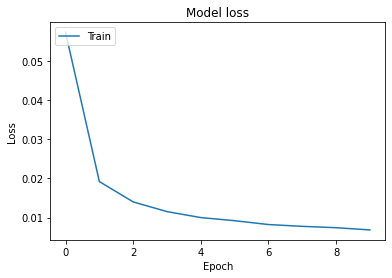

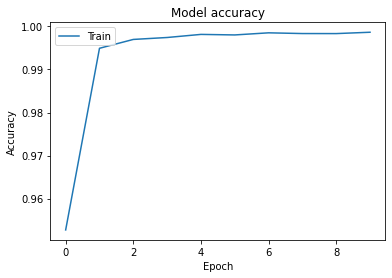

In [114]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

In [115]:
predictions = model.predict(X_test, verbose=1)

999/999 [==============================] - 4s 4ms/step


In [116]:
predictions

array([[0.02260284, 0.9954551 ],
       [0.01862024, 0.9703002 ],
       [0.0113273 , 0.97841865],
       ...,
       [0.9842432 , 0.01876891],
       [0.97663194, 0.01270163],
       [0.02070132, 0.9568423 ]], dtype=float32)

In [117]:
model.evaluate(X_test, Y_test)

999/999 [==============================] - 3s 3ms/step - loss: 0.0012 - acc: 1.0000


[0.0012265207478776574, 1.0]

In [118]:
CNNandLSTM_model = model

In [119]:
predictcv=np.argmax(predictions,axis=1)
actual_valuecv=np.argmax(Y_test,axis=1)
showResults(actual_valuecv, predictcv)

Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[ 8198     0]
 [    0 23750]]


In [120]:
hyd = accuracy_score(actual_valuecv, predictcv)
f1hyd=f1_score(actual_valuecv, predictcv, average='weighted') 

# BiLSTM

In [121]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [122]:
from keras.callbacks import EarlyStopping
from keras.layers import Activation
es=EarlyStopping(patience=7)
model=Sequential()
model.add(Bidirectional(LSTM(13,input_shape=(X_train.shape[1],X_train.shape[2]))))
model.add(Dense(units=2))
model.add(Activation('sigmoid'))
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['acc'])

In [123]:
history = model.fit(X_train, Y_train,epochs=10)

Epoch 1/10
2996/2996 [==============================] - 20s 7ms/step - loss: 0.1974 - acc: 0.7376
Epoch 2/10
2996/2996 [==============================] - 24s 8ms/step - loss: 0.1782 - acc: 0.7490
Epoch 3/10
2996/2996 [==============================] - 24s 8ms/step - loss: 0.1667 - acc: 0.7490
Epoch 4/10
2996/2996 [==============================] - 24s 8ms/step - loss: 0.1532 - acc: 0.7490
Epoch 5/10
2996/2996 [==============================] - 24s 8ms/step - loss: 0.1380 - acc: 0.7490
Epoch 6/10
2996/2996 [==============================] - 24s 8ms/step - loss: 0.1217 - acc: 0.7947
Epoch 7/10
2996/2996 [==============================] - 24s 8ms/step - loss: 0.1049 - acc: 0.8972
Epoch 8/10
2996/2996 [==============================] - 24s 8ms/step - loss: 0.0884 - acc: 0.9315
Epoch 9/10
2996/2996 [==============================] - 24s 8ms/step - loss: 0.0731 - acc: 0.9713
Epoch 10/10
2996/2996 [==============================] - 24s 8ms/step - loss: 0.0576 - acc: 0.9966


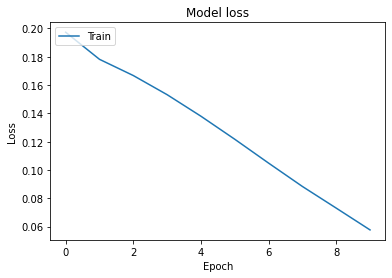

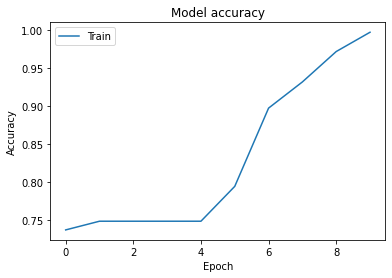

In [124]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

In [125]:
predictions = model.predict(X_test, verbose=1)

999/999 [==============================] - 2s 2ms/step


In [126]:
model.evaluate(X_test, Y_test)

999/999 [==============================] - 2s 2ms/step - loss: 0.0511 - acc: 0.9984


[0.05106104165315628, 0.9984349608421326]

In [127]:
predictcv=np.argmax(predictions,axis=1)
actual_valuecv=np.argmax(Y_test,axis=1)
showResults(actual_valuecv, predictcv)

Accuracy  : 0.9984349568048078
Precision : 0.9984382447106801
f1Score : 0.9984333860276012
[[ 8148    50]
 [    0 23750]]


In [128]:
bilstm = accuracy_score(actual_valuecv, predictcv)
f1bilstm=f1_score(actual_valuecv, predictcv, average='weighted') 

# GRU

In [129]:
from keras.layers import Dense, Dropout, Embedding, GRU
es=EarlyStopping(patience=7)
model=Sequential()
model.add(GRU(13,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(units=2))
model.add(Activation('sigmoid'))
model.compile(loss='squared_hinge',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 13)                624       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 28        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 652
Trainable params: 652
Non-trainable params: 0
_________________________________________________________________


In [130]:
history = model.fit(X_train, Y_train,epochs=10)

Epoch 1/10
2996/2996 [==============================] - 17s 6ms/step - loss: 0.8702 - acc: 0.7490
Epoch 2/10
2996/2996 [==============================] - 22s 7ms/step - loss: 0.7740 - acc: 0.7490
Epoch 3/10
2996/2996 [==============================] - 22s 8ms/step - loss: 0.7201 - acc: 0.7490
Epoch 4/10
2996/2996 [==============================] - 22s 7ms/step - loss: 0.6876 - acc: 0.7490: 0s - loss: 0.687
Epoch 5/10
2996/2996 [==============================] - 23s 8ms/step - loss: 0.6685 - acc: 0.7490
Epoch 6/10
2996/2996 [==============================] - 23s 8ms/step - loss: 0.6567 - acc: 0.7490
Epoch 7/10
2996/2996 [==============================] - 23s 8ms/step - loss: 0.6490 - acc: 0.7490
Epoch 8/10
2996/2996 [==============================] - 23s 8ms/step - loss: 0.6438 - acc: 0.7490
Epoch 9/10
2996/2996 [==============================] - 23s 8ms/step - loss: 0.6402 - acc: 0.7490
Epoch 10/10
2996/2996 [==============================] - 23s 8ms/step - loss: 0.6376 - acc: 0.7490


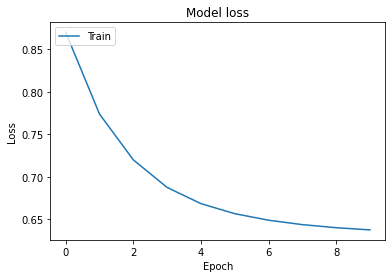

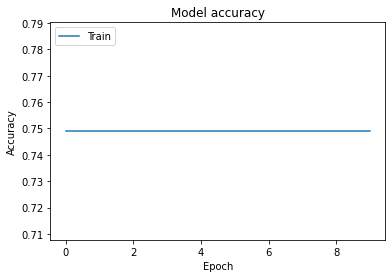

In [131]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

In [132]:
model.evaluate(X_test, Y_test)

999/999 [==============================] - 2s 2ms/step - loss: 0.6393 - acc: 0.7434


[0.6393243670463562, 0.7433955073356628]

In [133]:
predictions = model.predict(X_test, verbose=1)
predictcv=np.argmax(predictions,axis=1)
actual_valuecv=np.argmax(Y_test,axis=1)
showResults(actual_valuecv, predictcv)

999/999 [==============================] - 2s 2ms/step
Accuracy  : 0.743395517716289
Precision : 0.5526368957606693
f1Score : 0.6339776489555051
[[    0  8198]
 [    0 23750]]


C:\Users\naveen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
gru = accuracy_score(actual_valuecv, predictcv)
f1gru = f1_score(actual_valuecv, predictcv, average='weighted') 

# Comparison

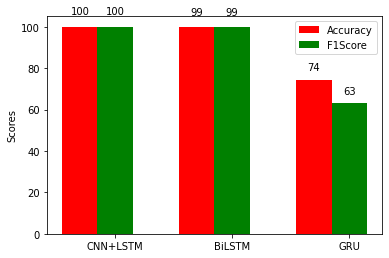

In [135]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.3      # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [hyd*100,bilstm*100,gru*100]

rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [f1hyd*100,f1bilstm*100,f1gru*100]
rects2 = ax.bar(ind+width, zvals, width, color='g')


ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('CNN+LSTM','BiLSTM','GRU') )
ax.legend( (rects1[0], rects2[0]), ('Accuracy', 'F1Score') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [136]:
score = [hyd*100,bilstm*100,gru*100]

In [137]:
#make variabel for save the result and to show it
classifier = ('CNN+LSTM','BiLSTM','GRU')
y_pos = np.arange(len(classifier))
print(y_pos)
print(score)

[0 1 2]
[100.0, 99.84349568048077, 74.33955177162889]


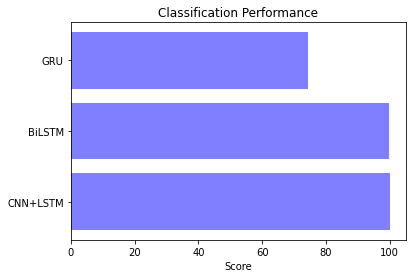

In [138]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, score, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Score')
plt2.title('Classification Performance')
plt2.show()

In [101]:
import joblib
filename = 'model.sav'
joblib.dump(CNNandLSTM_model, filename)

INFO:tensorflow:Assets written to: ram://c9c09f79-36f1-453f-968d-569336d32875/assets


INFO:tensorflow:Assets written to: ram://c9c09f79-36f1-453f-968d-569336d32875/assets


['model.sav']